In [25]:
convote_train_files_path = 'data_stage_one/training_set/*.txt'
convote_test_files_path = 'data_stage_one/test_set/*.txt'

In [26]:
from sklearn.manifold import TSNE
from collections import Counter
from six.moves import cPickle
from gensim.models import Word2Vec as w2v
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import os
import sys
import io
import re
import json
import pickle
import numpy as np
import pandas as pd

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

In [28]:
from keras.layers import GRU, RNN
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)


In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from yellowbrick.text import TSNEVisualizer
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
from collections import Counter


In [52]:
# Others

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

from sklearn.manifold import TSNE
import glob

In [32]:
convote_train_files = glob.glob(convote_train_files_path)
convote_test_files = glob.glob(convote_test_files_path)

In [34]:
filepath_dict = {'convote_train': convote_train_files,
                 'convote_test': convote_test_files}

In [35]:
convote_data = []

for data_type, filenames in filepath_dict.items():
    for i in range(len(filenames)):
        f = open(filenames[i], 'r')
        f_text = f.read()
        #print(f_text)
        f.close()
        party = filenames[i].split('_')[-1][0]
        sample_group = data_type.split('_')[-1]
        #print(review_sentiment)
        review_label = 0 if party == 'D' else 1
        #print(review_label)
        convote_data.append([f_text, party, sample_group, review_label])
      

In [36]:
convote_data = pd.DataFrame(convote_data)

In [37]:
convote_data = convote_data.rename(index=str, columns={0: 'text', 1: 'party', 2: 'group', 3: 'party_label'})

In [40]:
def clean_text(text):
    #remove punctuation
    #text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) > 1]
    
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
 
    # Tokenize: Split the sentence into words
    tokens = nltk.word_tokenize(text)
  
    #lemmatize the text   

    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    text = " ".join(lemmatized_words)
    return text

# apply the above function to df['text']


In [38]:
convote_data

,text,party,group,party_label
0,"mr. chairman , will the gentlewoman yield ? \n",D,train,0
1,"mr. speaker , i yield myself such time as i ma...",R,train,1
2,"mr. speaker , i am always amazed to hear the r...",D,train,0
3,"mr. speaker , i yield 3 minutes to the gentlem...",R,train,1
4,"mr. chairman , i yield myself such time as i m...",R,train,1
5,"mr. speaker , will the gentleman yield ? \n",R,train,1
6,"mr. speaker , i rise in support of the class a...",R,train,1
7,"mr. chairman , the congressional research serv...",D,train,0
8,"reclaiming my time , with all due respect , th...",D,train,0
9,"mr. chairman , i yield 2 minutes to the gentle...",D,train,0


In [41]:
convote_data['text'] = convote_data['text'].map(lambda x: clean_text(x))

In [59]:
convote_data.head()

,text,party,group,party_label
0,mr chairman gentlewoman yield,D,train,0
1,mr speaker yield time may consume respond good...,R,train,1
2,mr speaker always amazed hear remark colleague...,D,train,0
3,mr speaker yield minute gentleman georgia mr n...,R,train,1
4,mr chairman yield time may consume mr chairman...,R,train,1


In [47]:
data = pd.concat([convote_data['text'], convote_data['party_label']],axis=1, keys=['text', 'labels'])
#0 indicates democratic and 1 indicates republican

In [48]:
data.head()

,text,labels
0,mr chairman gentlewoman yield,0
1,mr speaker yield time may consume respond good...,1
2,mr speaker always amazed hear remark colleague...,0
3,mr speaker yield minute gentleman georgia mr n...,1
4,mr chairman yield time may consume mr chairman...,1


In [54]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['text'])
label = data['labels']

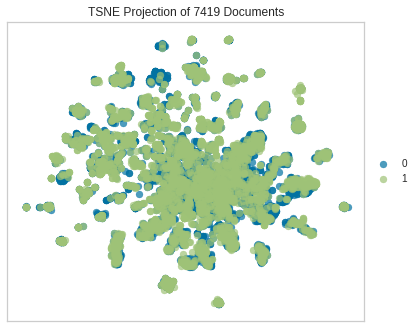

In [65]:
tsne = TSNEVisualizer(colors=['red','blue'])
tsne.fit(X,label)
tsne.poof(colors=['red','blue'])

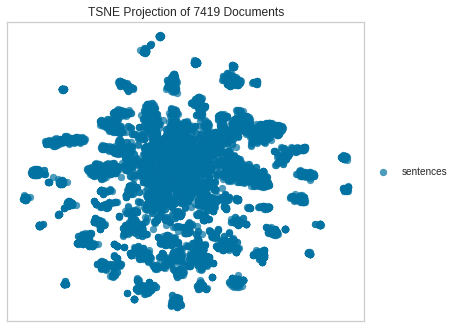

In [56]:
# Don't color points with their classes
tsne = TSNEVisualizer(labels=["sentences"])
tsne.fit(X)
tsne.poof()

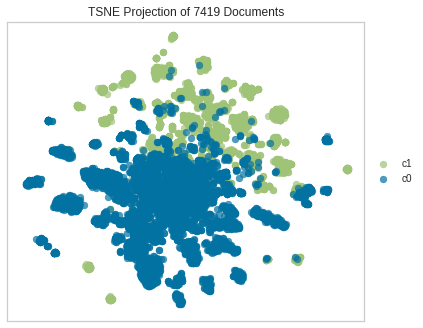

In [57]:
# Apply clustering instead of class names.
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=2)
clusters.fit(X)

tsne = TSNEVisualizer()
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()

#c0 = democratic
#c1 = republican
